In [230]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08


In [231]:
!pip install kaggle
!chmod 600 data/kaggle.json

In [3]:
!kaggle datasets download -d malekzadeharman/persian-image-captioning-dataset -p /content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08/data/

Dataset URL: https://www.kaggle.com/datasets/malekzadeharman/persian-image-captioning-dataset
License(s): CC-BY-SA-4.0
100% 1.65G/1.65G [00:29<00:00, 46.1MB/s]
100% 1.65G/1.65G [00:29<00:00, 60.8MB/s]


In [17]:
import zipfile
import os

zip_file_path = os.path.join("data/", "persian-image-captioning-dataset.zip")

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("data/")

In [19]:
!pip -q install hazm
!pip -q install arabic-reshaper
!pip install python-bidi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.8/238.8 kB 27.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.24.3 which is incompatible.


In [232]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import hazm
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from bidi.algorithm import get_display
import arabic_reshaper
import hazm
import json
import random
from bidi.algorithm import get_display

In [233]:
dataset_dir = "data/images/"

image_paths = []
for dirname, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))

image_paths

['data/images/139406241348383966088013.jpg',
 'data/images/139406241348383966088014.jpg',
 'data/images/139406241348384896088013.jpg',
 'data/images/139406241348385836088013.jpg',
 'data/images/139406241348386616088013.jpg',
 'data/images/139406241348387396088013.jpg',
 'data/images/139406241348388176088013.jpg',
 'data/images/139406241348389116088013.jpg',
 'data/images/139406241348393166088013.jpg',
 'data/images/139406241348394256088013.jpg',
 'data/images/139406241348395356088013.jpg',
 'data/images/13940624134839676088013.jpg',
 'data/images/139406241348397226088013.jpg',
 'data/images/139406241348398476088013.jpg',
 'data/images/139406241348399256088013.jpg',
 'data/images/139406241348402056088013.jpg',
 'data/images/139406241348403156088013.jpg',
 'data/images/139406241348404396088013.jpg',
 'data/images/13940624134840816088013.jpg',
 'data/images/139406241348409856088013.jpg',
 'data/images/139406241348415006088013.jpg',
 'data/images/139507021035476058727863.jpg',
 'data/image

In [234]:
news_df = pd.read_json(dataset_dir + "news.json", encoding='utf-8-sig')

print("data frame size: ", news_df.shape)
news_df

data frame size:  (1459, 6)


,title,description,reporter,time,category,images
0,غبارروبی مضجع شریف حضرت معصومه(س),مراسم خطبه خوانی و غبارروبی مضجع شریف حضرت مع...,آهویی - مریزاد,۰۹ آبان ۱۴۰۰ - ۱۷:۵۰,باشگاه خبرنگاران پویا,"[140008091737564223944594.jpg, 140008091737564..."
1,شورآباد,قالقاچی ، روستایی است از توابع بخش انزل در شه...,مجتبی اسماعیل زاده,۰۴ دی ۱۳۹۶ - ۱۰:۴۷,مستند,"[139603131324563911057744.jpg, 139603131324563..."
2,مشکلات زیست محیطی مالوجه - کردستان,مالوجه در بخش دلبران، با قریب به ۵هزار نفر جم...,کیوان فیروزه ای,۱۰ مهر ۱۴۰۰ - ۰۹:۲۲,استانها,"[1400030913402621922879884.jpg, 14000309134026..."
3,همایش علمای شیعه و سنی - گرگان,همایش علمای شیعه و سنی با موضوع سیره نبوی و م...,مصطفی حسن زاده,۲۵ مهر ۱۴۰۰ - ۱۳:۵۵,استانها,"[1400072513020612623840104.jpg, 14000725130206..."
4,افتتاح بیمارستان سریع الاحداث درمان اضطراری جم...,در جهت کمک به روند درمان و سرویس دهی به بیمار...,عبدالرحمن رافتی,۲۶ مرداد ۱۴۰۰ - ۱۴:۳۴,استانها,"[1400052613510297923408304.jpg, 14000526135102..."
...,...,...,...,...,...,...
1454,آئین تعویض پرچم گنبد حرم حضرت عبدالعظیم حسنی(ع),آئین تعویض پرچم گنبد حرم سیدالکریم (ع) عصر ام...,محمدحسین موحدی نژاد,۱۸ آبان ۱۴۰۰ - ۲۱:۲۹,باشگاه خبرنگاران پویا,"[1400081820552358124020784.jpg, 14000818205523..."
1455,آئین تعویض پرچم گنبد حرم حضرت عبدالعظیم حسنی(ع),آئین تعویض پرچم گنبد حرم سیدالکریم (ع) عصر ام...,محمدحسین موحدی نژاد,۱۸ آبان ۱۴۰۰ - ۲۱:۲۹,باشگاه خبرنگاران پویا,"[1400081820552358124020784.jpg, 14000818205523..."
1456,آئین تعویض پرچم گنبد حرم حضرت عبدالعظیم حسنی(ع),آئین تعویض پرچم گنبد حرم سیدالکریم (ع) عصر ام...,محمدحسین موحدی نژاد,۱۸ آبان ۱۴۰۰ - ۲۱:۲۹,باشگاه خبرنگاران پویا,"[1400081820552358124020784.jpg, 14000818205523..."
1457,آئین تعویض پرچم گنبد حرم حضرت عبدالعظیم حسنی(ع),آئین تعویض پرچم گنبد حرم سیدالکریم (ع) عصر ام...,محمدحسین موحدی نژاد,۱۸ آبان ۱۴۰۰ - ۲۱:۲۹,باشگاه خبرنگاران پویا,"[1400081820552358124020784.jpg, 14000818205523..."


In [235]:
# Create a dictionary to store image paths with their titles
image_title_dict = {}

# Populate the dictionary with image paths and their corresponding titles
for index, row in news_df.iterrows():
    for image in row['images']:
        image_path = os.path.join(dataset_dir, image)
        if image_path in image_paths:
            image_title_dict[image_path] = row['title']

In [236]:
image_title_dict

{'data/images/140008091737564223944594.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/140008091737564223944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375771423944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375921423944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375944923944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375690223944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917380013623944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375726123944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375749523944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375737023944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917380068323944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data/images/1400080917375713623944593.jpg': 'غبارروبی مضجع شریف حضرت معصومه(س)',
 'data

In [237]:
# Function to reshape and display Farsi text
def reshape_text(text):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

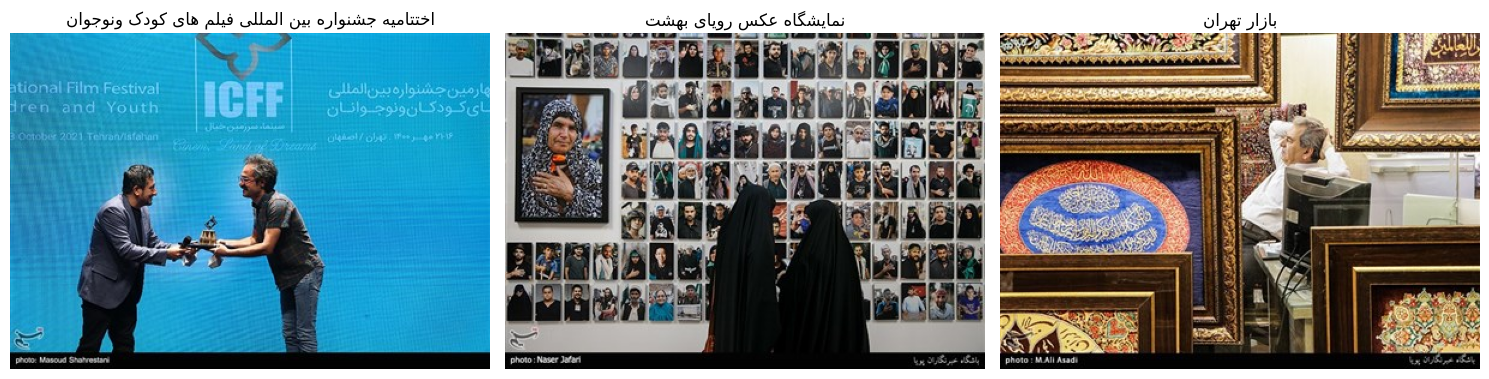

In [239]:
random_images = random.sample(list(image_title_dict.items()), 3)

# Plot the selected images with their captions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (image_path, title) in zip(axes, random_images):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(reshape_text(title), fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [240]:
def plot_scatter_tokens(dataset):
    token_len = dataset['title'].apply(lambda cap:len(cap.split()))

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.hist(token_len, bins=30, color='green', edgecolor='white')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.subplot(132)
    plt.boxplot(token_len)
    plt.xlabel('Token Length')
    plt.ylabel('Lenght')
    plt.subplot(133)
    plt.plot(token_len)
    plt.xlabel('Tokens')
    plt.ylabel('Lenght')


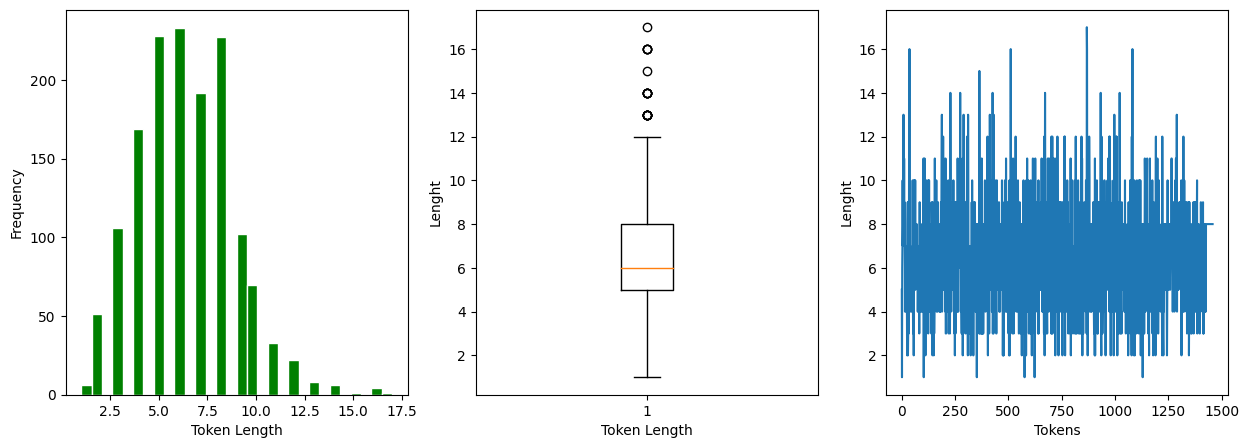

In [241]:
plot_scatter_tokens(news_df)

In [242]:
# Calculate the number of tokens in each title
title_lengths = news_df['title'].apply(lambda x: len(x.split()))

# Find the maximum and minimum number of tokens
max_tokens = title_lengths.max()
min_tokens = title_lengths.min()

print("maximum token: ", max_tokens)
print("minimum token: ", min_tokens)

maximum token:  17
minimum token:  1


In [243]:
news_df.shape[0]

1459

In [244]:
def dataset_split(df, dataset_len=1459, min_token=1, max_token=17, train_size=0.8, test_size = 0.1, shuffle=True):
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)

    filterd_df = df[df['title'].apply(lambda cap: min_token <= len(cap.split()) <= max_token )][:dataset_len]
    print("total data: ", len(filterd_df))

    train_size = int(dataset_len * train_size)
    test_size = int(dataset_len * test_size)

    train_df, test_valid_df = train_test_split(filterd_df,test_size=0.2,random_state=42)
    test_df, valid_df = train_test_split(test_valid_df,test_size=0.5,random_state=42)


    return train_df.reset_index(drop=True), valid_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [245]:
train_df, valid_df, test_df = dataset_split(news_df, dataset_len=news_df.shape[0])
print("Number of training samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))
print("Number of test samples: ", len(test_df))

total data:  1459
Number of training samples:  1167
Number of validation samples:  146
Number of test samples:  146


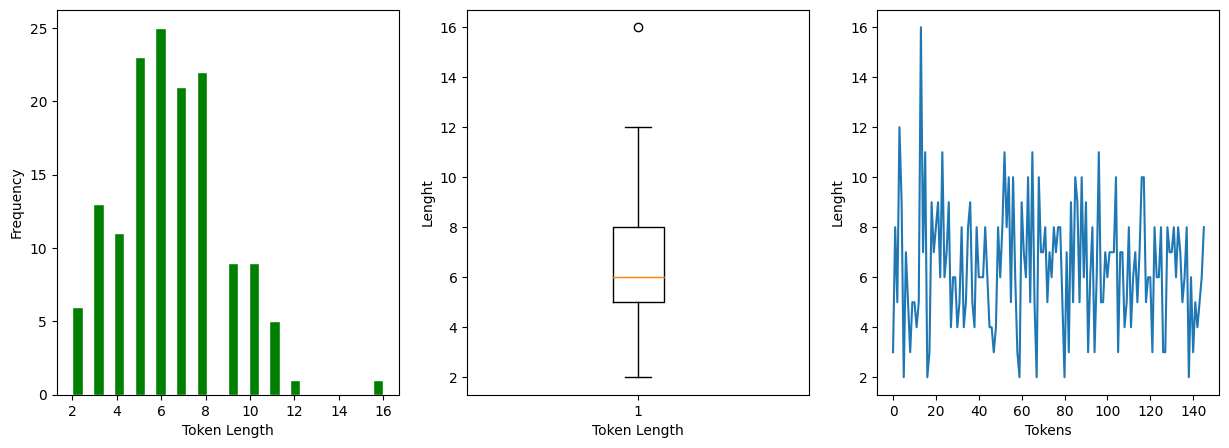

In [246]:
plot_scatter_tokens(test_df)

In [247]:
all_caption_data = news_df['title'].str.cat()
with open('data/all_captions.txt','w') as file:
    file.write(all_caption_data)

In [248]:
"""
## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).
"""

tokenizer = hazm.WordTokenizer()
persian_tokens = tokenizer.tokenize(all_caption_data)

print('all tokens len:', len(persian_tokens))
print('len unique tokens:', len(set(persian_tokens)))

VOCAB_SIZE = len(set(persian_tokens))
SEQ_LENGTH = 25

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
)

vectorization.adapt(persian_tokens)

all tokens len: 8404
len unique tokens: 3281


In [249]:
vocab = vectorization.get_vocabulary()
len(vocab)

3263

In [250]:
print(train_df['title'][0])
vectorization(train_df['title'][0])

پایدار در روشنایی


<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([   1,    2, 2303,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [251]:
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomContrast(0.3),
    ]
)

In [252]:
import cv2

_img = cv2.imread(dataset_dir + '1396121510150694313529973.jpg')
h, w, _ = _img.shape
print('width: ', w)
print('height:', h)

width:  400
height: 280


In [253]:
# Flatten the DataFrame

import pandas as pd

def flatten_dataframe(df):
    flat_data = []
    for _, row in df.iterrows():
        for image in row['images']:
            flat_data.append({'title': row['title'], 'image_path': os.path.join(dataset_dir, image)})
    return pd.DataFrame(flat_data)

# Flatten the DataFrames
train_df = flatten_dataframe(train_df)
valid_df = flatten_dataframe(valid_df)
test_df = flatten_dataframe(test_df)


In [254]:
# Adjust the TensorFlow Dataset Creation

import tensorflow as tf

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (h, w)

def decode_image_and_vectorize(path, caption):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)

    vcaption = vectorization(caption)

    return img, vcaption

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((list(df['image_path']), list(df['title'])))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(decode_image_and_vectorize, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# Create datasets
train_dataset = make_dataset(train_df)
valid_dataset = make_dataset(valid_df)
test_dataset = make_dataset(test_df)


In [255]:
batch = next(iter(train_dataset))
print(batch[0].shape)
print(batch[1].shape)

(64, 280, 400, 3)
(64, 25)


In [256]:
os.chdir("src/")

In [257]:
"""
## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
                    based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data
                    (sequences) as inputs and tries to learn to generate the caption.
"""

from keras import layers
from keras.applications import efficientnet
from TransformerModel import TransformerEncoderBlock, TransformerDecoderBlock


EPOCHS = 60
EMBED_DIM = 512
FF_DIM = 512

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2, seq_len=SEQ_LENGTH, vocab_size=VOCAB_SIZE)

In [258]:
"""
## Building ImageCaptioningModel
"""

from ICModel import ImageCaptioningModel


caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

In [259]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )
    def get_config(self):
      config = {
      # 'd_model': self.d_model
      'warmup_steps': self.warmup_steps,

      }
      return config


num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [261]:
os.chdir("../")

In [262]:
"""
## Model training
"""
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/60
518/518 [==============================] - ETA: 0s - loss: 7.3117 - acc: 0.0285

InvalidArgumentError: Graph execution error:

Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Input is empty.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
	 [[sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert/data_1/_98]]
  (1) INVALID_ARGUMENT:  Input is empty.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_94057]